In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta, timezone
from dateutil.relativedelta import relativedelta
import io
import sys
import configparser

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

SPACETRACK_USER = config['SPACE_TRACK']['username']
SPACETRACK_PASS = config['SPACE_TRACK']['password']
SPACETRACK_URI = "https://www.space-track.org"
SPACETRACK_LOGIN_URL = SPACETRACK_URI + '/ajaxauth/login'
SPACETRACK_LOGOUT_URL = SPACETRACK_URI + '/ajaxauth/logout'
SPACETRACK_QUERY_URL = SPACETRACK_URI + '/basicspacedata/query'

In [3]:
NORAD_ID = 23560 # ERS-2
MONTHS_PRIOR = 3

In [4]:
GM_EARTH = 3.986008e14

In [5]:
def calculate_epoch_dt(satrec_obj):
    """Calculates datetime object from Satrec epoch fields."""
    year = satrec_obj.epochyr
    if year < 57:  # Y2K fix
        year += 2000
    else:
        year += 1900
    day = satrec_obj.epochdays
    day_int = int(day)
    frac_day = day - day_int
    base_date = datetime(year, 1, 1)
    dt_epoch = base_date + timedelta(days=day_int - 1, seconds=frac_day * 86400.0)
    return dt_epoch

In [6]:
print(f"Attempting to fetch data for NORAD ID: {NORAD_ID}...")

latest_tle_data = None
tle_data = None
latest_epoch_dt = None
tle_line1_latest = None
tle_line2_latest = None
sat_latest = None

with requests.Session() as session:
    # Login
    login_data = {'identity': SPACETRACK_USER, 'password': SPACETRACK_PASS}
    session.post(SPACETRACK_LOGIN_URL, data=login_data).raise_for_status()
    print("Space-Track login successful.")

    # Fetch Latest TLE
    latest_tle_query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/"
                           f"NORAD_CAT_ID/{NORAD_ID}/orderby/EPOCH%20desc/limit/1/format/tle")
    latest_tle_response = session.get(latest_tle_query_url)
    latest_tle_response.raise_for_status()
    latest_tle_data = latest_tle_response.text.strip()
    print("Fetched latest TLE.")

    # Parse Latest TLE and Determine Date Range
    if not latest_tle_data or len(latest_tle_data.splitlines()) < 2:
        print(f"Error: No valid latest TLE data found for NORAD ID {NORAD_ID}. Exiting.")
        sys.exit(1)

    latest_lines = latest_tle_data.splitlines()
    tle_line1_latest = latest_lines[-2].strip()
    tle_line2_latest = latest_lines[-1].strip()

    if tle_line1_latest.startswith('1 ') and tle_line2_latest.startswith('2 '):
        sat_latest = Satrec.twoline2rv(tle_line1_latest, tle_line2_latest)
        latest_epoch_dt = calculate_epoch_dt(sat_latest)
    else:
        print(f"Error: Fetched latest data does not look like a valid TLE:\n{latest_tle_data}\nExiting.")
        sys.exit(1)

    # Calculate Date Range for Historical Data
    END_DATE_dt = latest_epoch_dt
    START_DATE_dt = END_DATE_dt - relativedelta(months=MONTHS_PRIOR)
    END_DATE_str = END_DATE_dt.strftime('%Y-%m-%d')
    START_DATE_str = START_DATE_dt.strftime('%Y-%m-%d')

    print(f"Latest TLE Epoch: {latest_epoch_dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]} UTC")
    print(f"Querying historical TLEs from {START_DATE_str} to {END_DATE_str}")

    # Fetch Historical TLEs for the Date Range
    query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/NORAD_CAT_ID/{NORAD_ID}/"
                f"EPOCH/{START_DATE_str}--{END_DATE_str}/orderby/EPOCH%20asc/format/tle")
    tle_response = session.get(query_url)
    tle_response.raise_for_status()
    tle_data = tle_response.text
    print(f"Successfully fetched historical TLE data ({len(tle_data.splitlines()) // 2} sets found).")

    # Logout
    session.get(SPACETRACK_LOGOUT_URL)
    print("Logged out from Space-Track.")

# Final check for required data
if tle_data is None or latest_epoch_dt is None or sat_latest is None:
    print("Error: Failed to retrieve necessary data from Space-Track. Exiting.")
    sys.exit(1)

Attempting to fetch data for NORAD ID: 23560...
Space-Track login successful.
Fetched latest TLE.
Latest TLE Epoch: 2024-02-21 15:49:35.026 UTC
Querying historical TLEs from 2023-11-21 to 2024-02-21
Successfully fetched historical TLE data (303 sets found).
Logged out from Space-Track.


In [7]:
print("Parsing historical TLEs...")
lines = tle_data.strip().splitlines()
tles = []

line_idx = 0
while line_idx < len(lines) - 1:
    line1 = lines[line_idx].strip()
    line2 = lines[line_idx+1].strip()

    if not line1 or not line2:
        line_idx += 1
        continue

    if line1.startswith('1 ') and line2.startswith('2 '):
        try:
            sat = Satrec.twoline2rv(line1, line2)
            dt_epoch = calculate_epoch_dt(sat) # Use helper function

            # Extract ndot/2 directly from TLE Line 1 (columns 34-43)
            # (Keeping the original robust parsing logic)
            ndot_raw = line1[33:43].strip()
            ndot_formatted = "0.0" # Default value
            if ndot_raw: # Process only if not empty
                # Add implicit decimal point if missing and format allows
                if '.' not in ndot_raw and len(ndot_raw) > 1:
                    sign = ''
                    if ndot_raw.startswith(('-', '+')):
                        sign = ndot_raw[0]
                        ndot_raw = ndot_raw[1:]

                    exp_sign = ''
                    exp_val = ''
                    num_part = ndot_raw

                    # Simplified exponent detection
                    for exp_delim in ['-', '+', ' ']:
                        if exp_delim in ndot_raw:
                            parts = ndot_raw.split(exp_delim, 1)
                            if len(parts) == 2 and parts[1].isdigit():
                                num_part = parts[0]
                                exp_sign = '-' if exp_delim == '-' else '+'
                                exp_val = parts[1]
                                break # Found exponent

                    if exp_val: # If an exponent was found
                        ndot_formatted = f"{sign}.{num_part}e{exp_sign}{exp_val}"
                    elif num_part: # No exponent found, just add decimal
                         ndot_formatted = f"{sign}.{num_part}"

                else: # Already has decimal or is simple (e.g., '0')
                    ndot_formatted = ndot_raw

                # Final cleanup for scientific notation
                ndot_formatted = ndot_formatted.replace(' -','e-').replace(' +','e+')
                if 'e' not in ndot_formatted:
                     last_sign_idx = max(ndot_formatted.rfind('-'), ndot_formatted.rfind('+'))
                     if last_sign_idx > 0:
                         base = ndot_formatted[:last_sign_idx]
                         exponent = ndot_formatted[last_sign_idx:]
                         try:
                             float(base)
                             int(exponent) # Check parts are numeric
                             ndot_formatted = base + 'e' + exponent
                         except ValueError:
                             pass # Not a valid split

            # Now parse the scientific notation
            try:
                ndot_term = float(ndot_formatted)
            except ValueError:
                print(f"Warning: Could not parse ndot_term '{line1[33:43]}' (processed as '{ndot_formatted}') for TLE epoch {dt_epoch}. Setting to 0.")
                ndot_term = 0.0

            # Store parameters
            mean_motion_rad_min = sat.no_kozai
            mean_motion_rev_day = mean_motion_rad_min * (1440.0 / (2.0 * np.pi)) # 1440 = 60*24

            tles.append({
                'Epoch': dt_epoch,
                'MeanMotion_rad_min': mean_motion_rad_min,
                'MeanMotion_revday': mean_motion_rev_day,
                'Eccentricity': sat.ecco,
                'Inclination_deg': np.degrees(sat.inclo),
                'RAAN_deg': np.degrees(sat.nodeo),
                'ArgPerigee_deg': np.degrees(sat.argpo),
                'MeanAnomaly_deg': np.degrees(sat.mo),
                'Bstar': sat.bstar,
                'ndot_TERM_from_TLE': ndot_term, # ndot/2 in rev/day^2 from TLE
            })
            line_idx += 2  # Move to the next pair

        except Exception as e:
            print(f"ERROR processing TLE lines:\n{line1}\n{line2}\nError: {e}. Skipping pair.")
            line_idx += 2 # Skip this problematic pair

    else:
        # Skipping non-TLE line (less verbose in notebook)
        line_idx += 1

if not tles:
    print("No valid TLEs could be parsed from the downloaded historical data. Exiting.")
    sys.exit(1)

print(f"Successfully parsed {len(tles)} historical TLE sets.")
tle_df_raw = pd.DataFrame(tles)

Parsing historical TLEs...
Successfully parsed 303 historical TLE sets.


In [8]:
print("Calculating derived parameters for historical data...")
tle_df_raw['MeanMotion_rad_sec'] = tle_df_raw['MeanMotion_rad_min'] / 60.0
n_rad_per_sec = tle_df_raw['MeanMotion_rad_sec']

# Calculate Semi-Major Axis (SMA) in meters
valid_n = n_rad_per_sec > 1e-9 
tle_df_raw['SemiMajorAxis_m'] = np.nan
tle_df_raw.loc[valid_n, 'SemiMajorAxis_m'] = (GM_EARTH / n_rad_per_sec[valid_n]**2)**(1.0/3.0)
tle_df_raw['SemiMajorAxis_km'] = tle_df_raw['SemiMajorAxis_m'] / 1000.0

# Calculate Orbital Period in seconds
tle_df_raw['Period_sec'] = np.nan
tle_df_raw.loc[valid_n, 'Period_sec'] = 2.0 * np.pi / n_rad_per_sec[valid_n]

# Calculate Perigee and Apogee Altitudes
R_EARTH_KM_FOR_PLOT = 6378.135 
valid_sma = tle_df_raw['SemiMajorAxis_m'].notna()
tle_df_raw['AltitudePerigee_km'] = np.nan
tle_df_raw['AltitudeApogee_km'] = np.nan

rp_m = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 - tle_df_raw.loc[valid_sma, 'Eccentricity'])
ra_m = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 + tle_df_raw.loc[valid_sma, 'Eccentricity'])

tle_df_raw.loc[valid_sma, 'AltitudePerigee_km'] = (rp_m / 1000.0) - R_EARTH_KM_FOR_PLOT
tle_df_raw.loc[valid_sma, 'AltitudeApogee_km'] = (ra_m / 1000.0) - R_EARTH_KM_FOR_PLOT


original_rows = len(tle_df_raw)
essential_cols = ['SemiMajorAxis_m', 'AltitudePerigee_km', 'AltitudeApogee_km', 'Period_sec']
tle_df = tle_df_raw.dropna(subset=essential_cols).copy()
dropped_rows = original_rows - len(tle_df)
if dropped_rows > 0:
    print(f"Dropped {dropped_rows} historical rows due to invalid derived parameter calculations.")

if tle_df.empty:
    print("No valid historical data remains after calculating derived parameters. Cannot plot decay. Exiting.")
    sys.exit(1)

print("Historical derived parameter calculation complete.")
tle_df.set_index('Epoch', inplace=True)
tle_df.sort_index(inplace=True)

Calculating derived parameters for historical data...
Historical derived parameter calculation complete.


Plotting historical altitude decay...


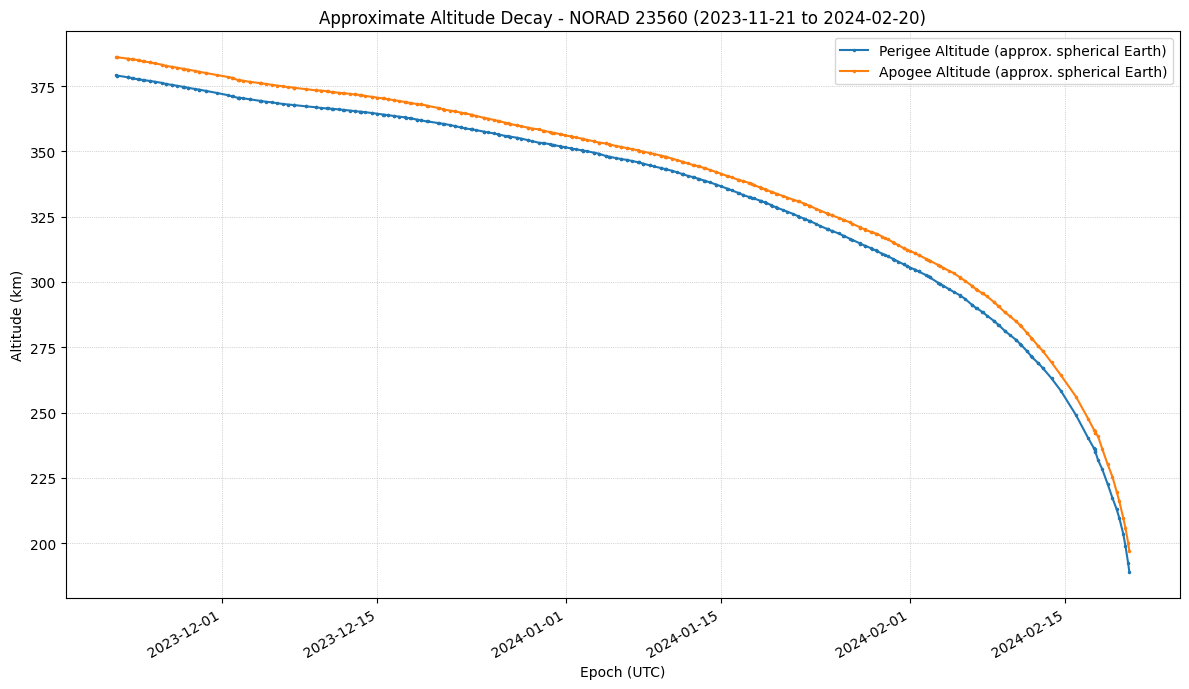

In [9]:
print("Plotting historical altitude decay...")
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(tle_df.index, tle_df['AltitudePerigee_km'], marker='.', markersize=3, linestyle='-', label='Perigee Altitude (approx. spherical Earth)')
ax1.plot(tle_df.index, tle_df['AltitudeApogee_km'], marker='.', markersize=3, linestyle='-', label='Apogee Altitude (approx. spherical Earth)')
ax1.set_xlabel('Epoch (UTC)')
ax1.set_ylabel('Altitude (km)')
ax1.set_title(f'Approximate Altitude Decay - NORAD {NORAD_ID} ({tle_df.index.min().strftime("%Y-%m-%d")} to {tle_df.index.max().strftime("%Y-%m-%d")})')
ax1.legend()
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

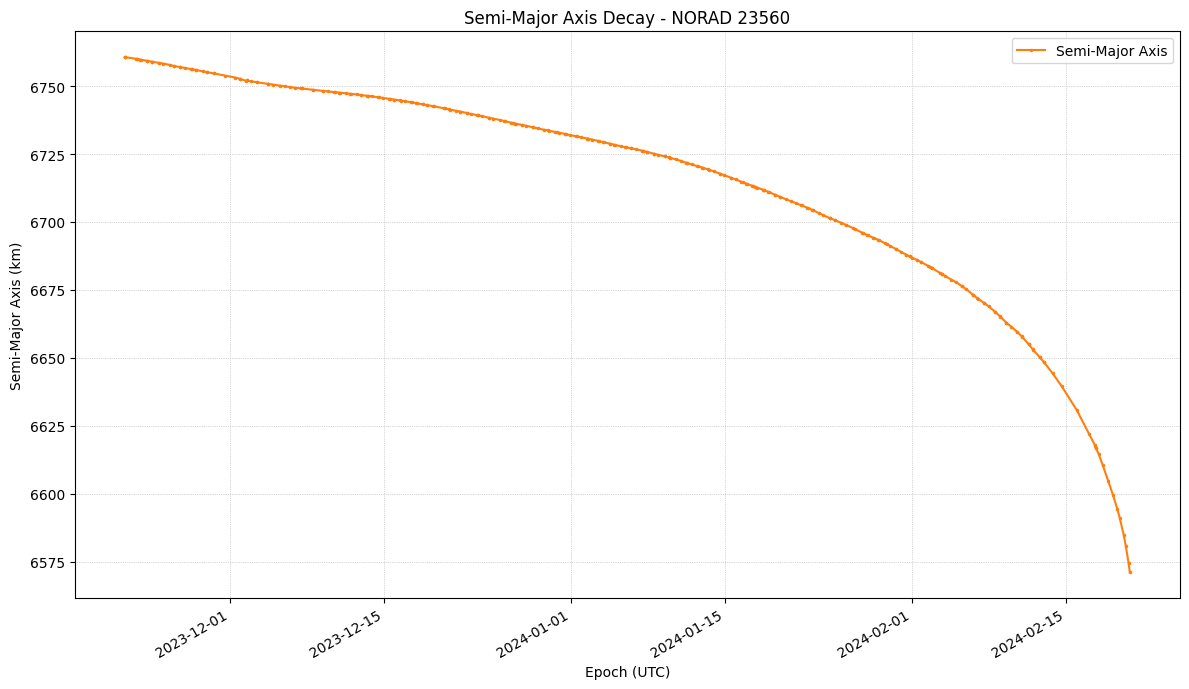

In [10]:
fig_sma, ax_sma = plt.subplots(figsize=(12, 7))
ax_sma.plot(tle_df.index, tle_df['SemiMajorAxis_km'], marker='.', markersize=3, linestyle='-', label='Semi-Major Axis', color='tab:orange')
ax_sma.set_xlabel('Epoch (UTC)')
ax_sma.set_ylabel('Semi-Major Axis (km)')
ax_sma.set_title(f'Semi-Major Axis Decay - NORAD {NORAD_ID}')
ax_sma.legend()
ax_sma.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_sma.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_sma.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig_sma.autofmt_xdate()
plt.tight_layout()
plt.show()

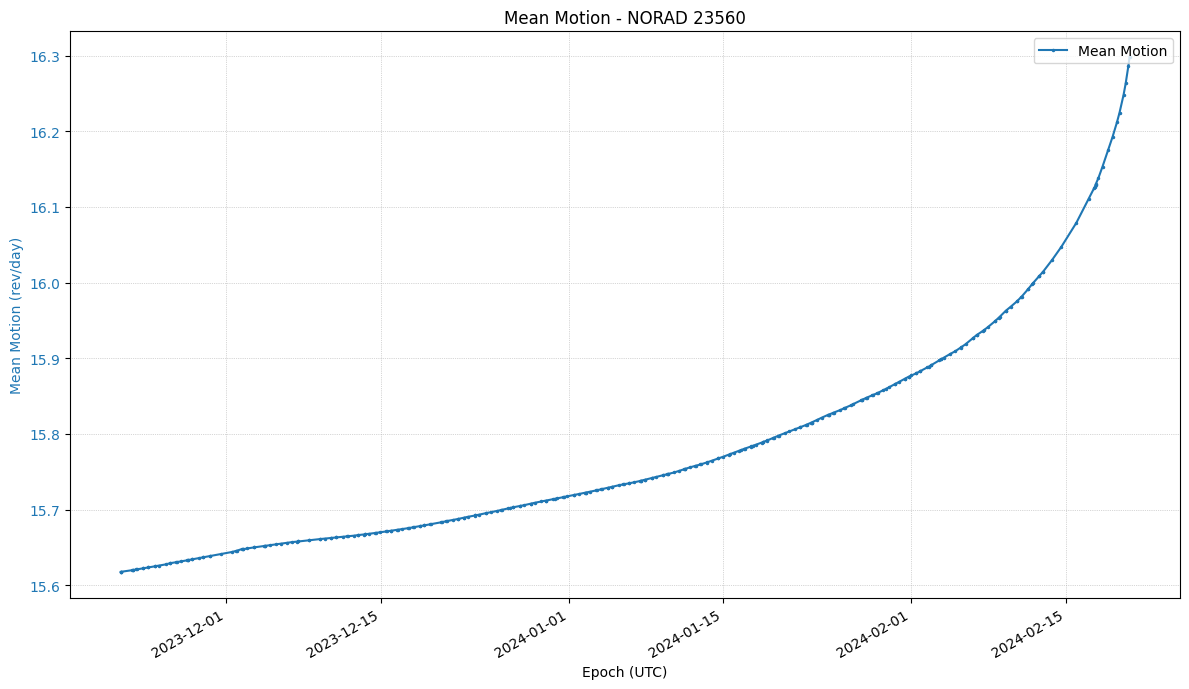

In [11]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
color1 = 'tab:blue'
ax1.plot(tle_df.index, tle_df['MeanMotion_revday'], marker='.', markersize=3, linestyle='-', color=color1, label='Mean Motion')
ax1.set_xlabel('Epoch (UTC)')
ax1.set_ylabel('Mean Motion (rev/day)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax1.set_title(f'Mean Motion - NORAD {NORAD_ID}')
ax1.legend(loc='upper right')
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

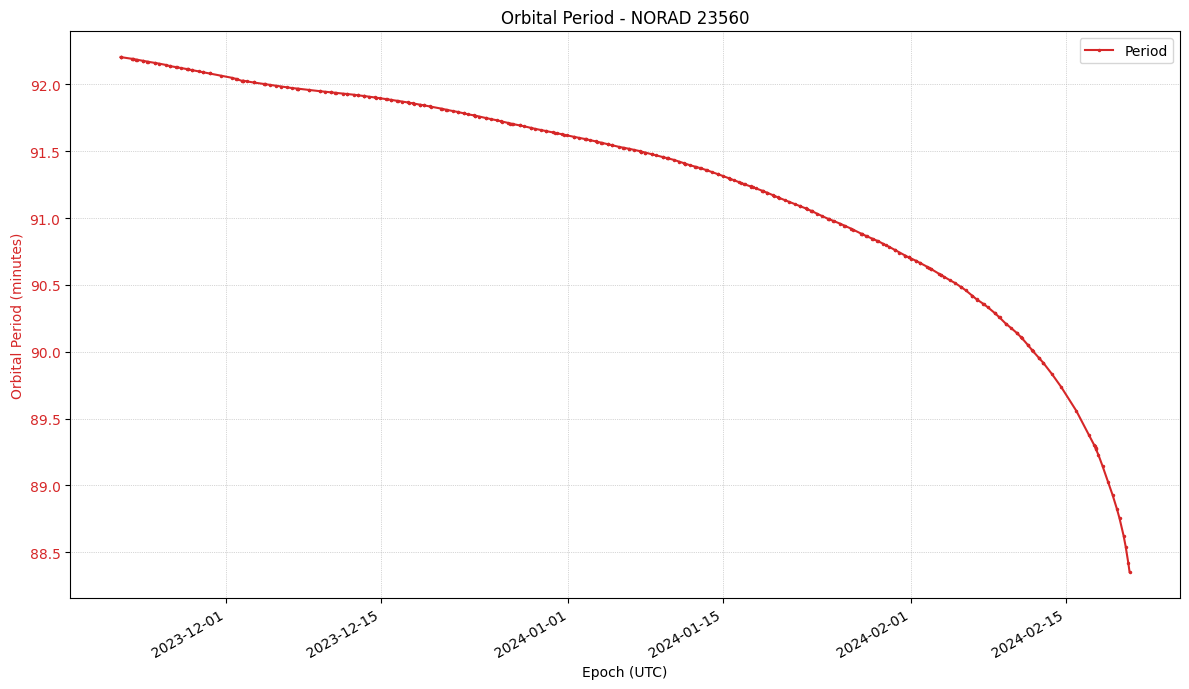

In [12]:
fig2, ax2 = plt.subplots(figsize=(12, 7))
color2 = 'tab:red'
ax2.plot(tle_df.index, tle_df['Period_sec'] / 60.0, marker='.', markersize=3, linestyle='-', color=color2, label='Period')
ax2.set_xlabel('Epoch (UTC)')
ax2.set_ylabel('Orbital Period (minutes)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax2.set_title(f'Orbital Period - NORAD {NORAD_ID}')
ax2.legend(loc='upper right')
fig2.autofmt_xdate()
plt.tight_layout()
plt.show()

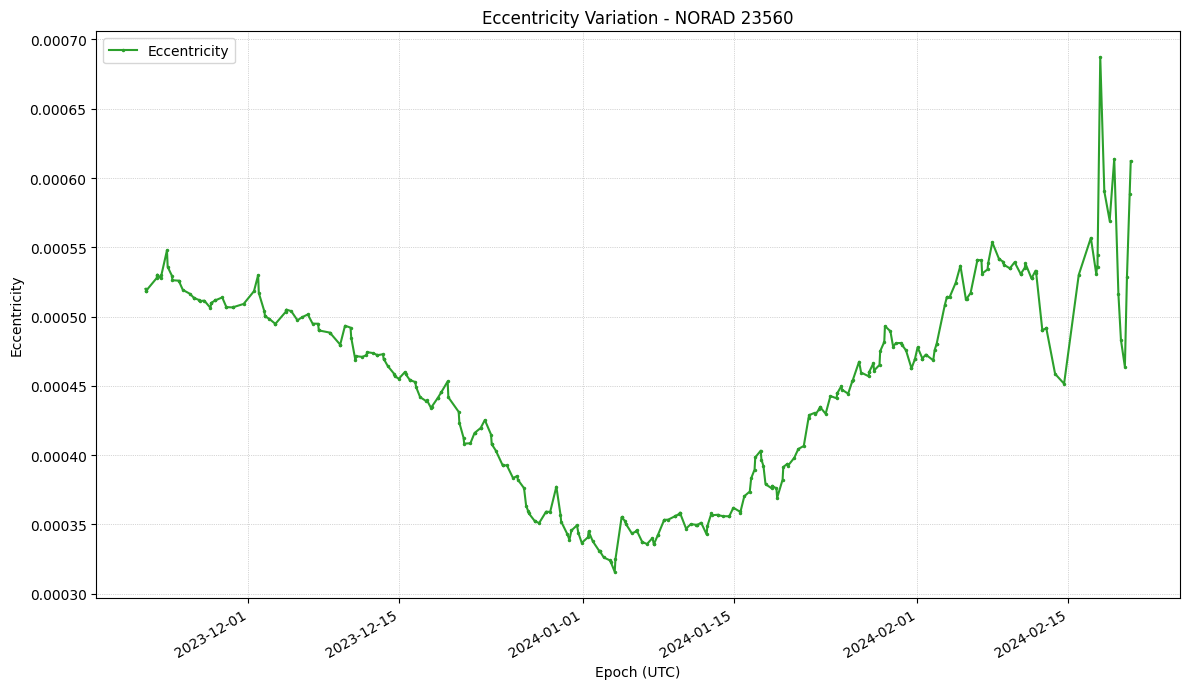

In [13]:
fig_ecc, ax_ecc = plt.subplots(figsize=(12, 7))
ax_ecc.plot(tle_df.index, tle_df['Eccentricity'], marker='.', markersize=3, linestyle='-', label='Eccentricity', color='tab:green')
ax_ecc.set_xlabel('Epoch (UTC)')
ax_ecc.set_ylabel('Eccentricity')
ax_ecc.set_title(f'Eccentricity Variation - NORAD {NORAD_ID}')
ax_ecc.legend()
ax_ecc.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_ecc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_ecc.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig_ecc.autofmt_xdate()
plt.tight_layout()
plt.show()

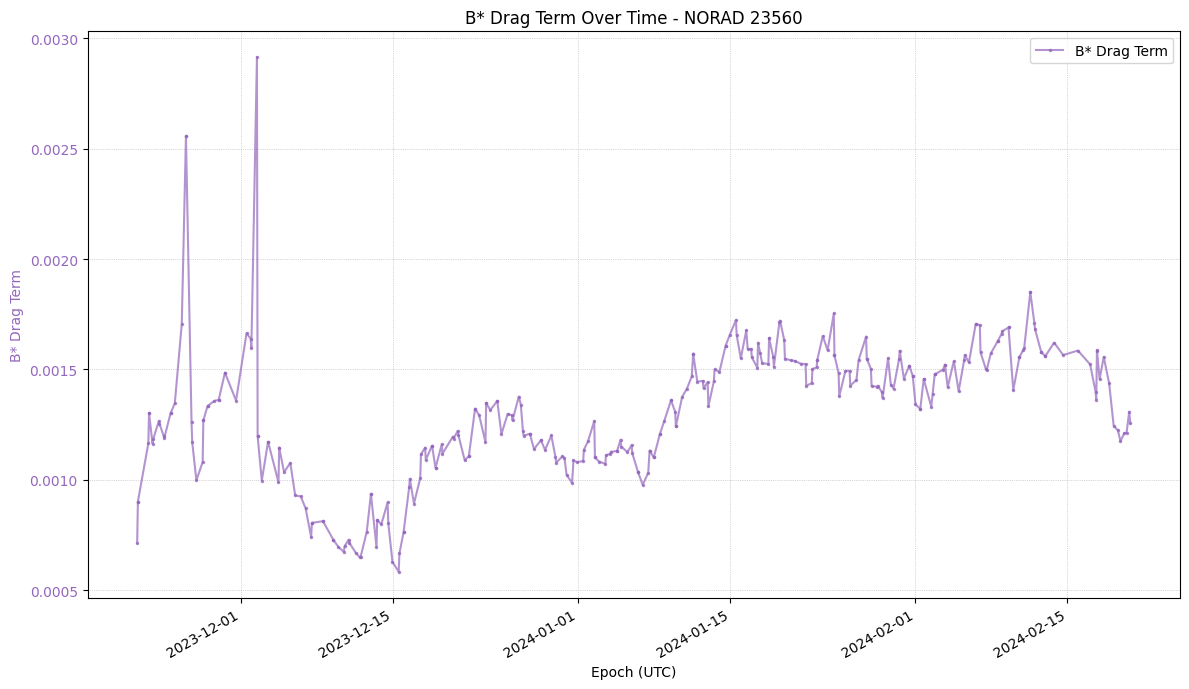

In [14]:
fig_bstar, ax_bstar = plt.subplots(figsize=(12, 7))
color1 = 'tab:purple'
ax_bstar.plot(tle_df.index, tle_df['Bstar'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color1, label='B* Drag Term')
ax_bstar.set_xlabel('Epoch (UTC)')
ax_bstar.set_ylabel('B* Drag Term', color=color1)
ax_bstar.tick_params(axis='y', labelcolor=color1)
ax_bstar.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_bstar.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_bstar.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax_bstar.set_title(f'B* Drag Term Over Time - NORAD {NORAD_ID}')
ax_bstar.legend(loc='upper right')
fig_bstar.autofmt_xdate()
plt.tight_layout()
plt.show()

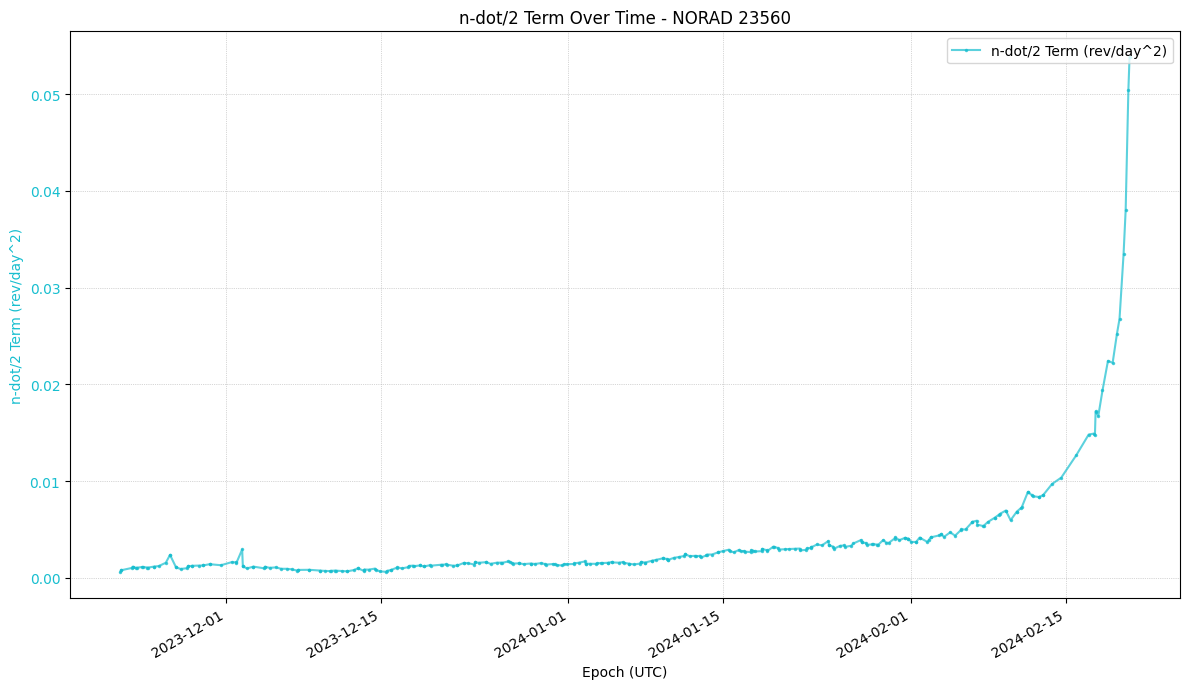

In [15]:
fig_ndot, ax_ndot = plt.subplots(figsize=(12, 7))
color2 = 'tab:cyan'
ax_ndot.plot(tle_df.index, tle_df['ndot_TERM_from_TLE'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color2, label='n-dot/2 Term (rev/day^2)')
ax_ndot.set_xlabel('Epoch (UTC)')
ax_ndot.set_ylabel('n-dot/2 Term (rev/day^2)', color=color2)
ax_ndot.tick_params(axis='y', labelcolor=color2)
ax_ndot.grid(True, which='both', linestyle=':', linewidth=0.5)
ax_ndot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax_ndot.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax_ndot.set_title(f'n-dot/2 Term Over Time - NORAD {NORAD_ID}')
ax_ndot.legend(loc='upper right')
fig_ndot.autofmt_xdate()
plt.tight_layout()
plt.show()

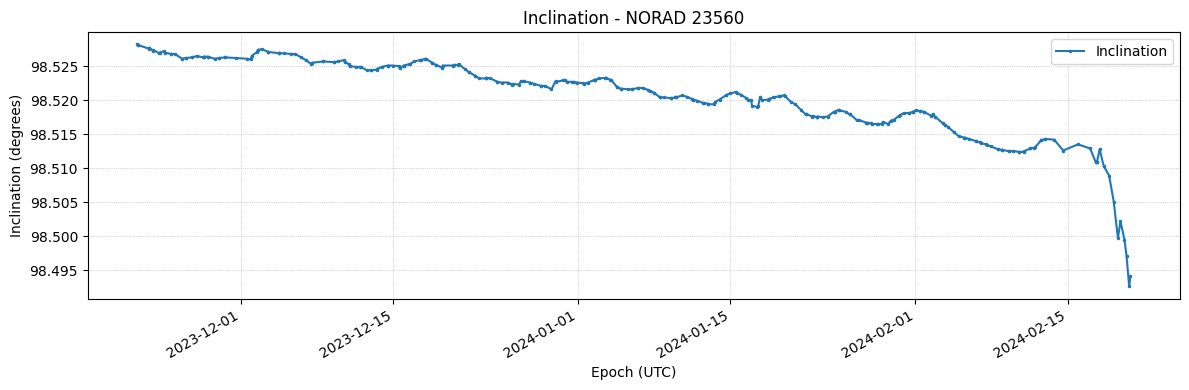

In [16]:
fig1, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(tle_df.index, tle_df['Inclination_deg'], marker='.', markersize=3, linestyle='-', label='Inclination')
ax1.set_xlabel('Epoch (UTC)')
ax1.set_ylabel('Inclination (degrees)')
ax1.set_title(f'Inclination - NORAD {NORAD_ID}')
ax1.legend(loc='best')
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

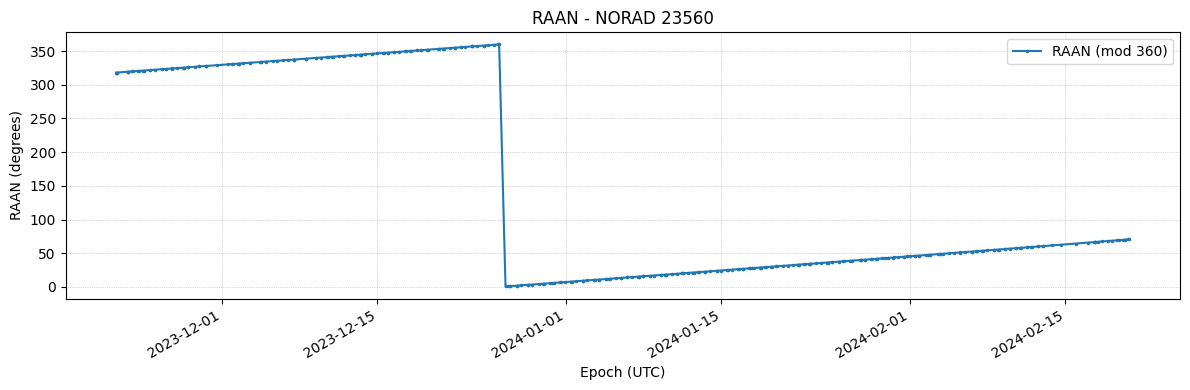

In [17]:
fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.plot(tle_df.index, tle_df['RAAN_deg'] % 360, marker='.', markersize=3, linestyle='-', label='RAAN (mod 360)')
ax2.set_xlabel('Epoch (UTC)')
ax2.set_ylabel('RAAN (degrees)')
ax2.set_title(f'RAAN - NORAD {NORAD_ID}')
ax2.legend(loc='best')
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig2.autofmt_xdate()
plt.tight_layout()
plt.show()

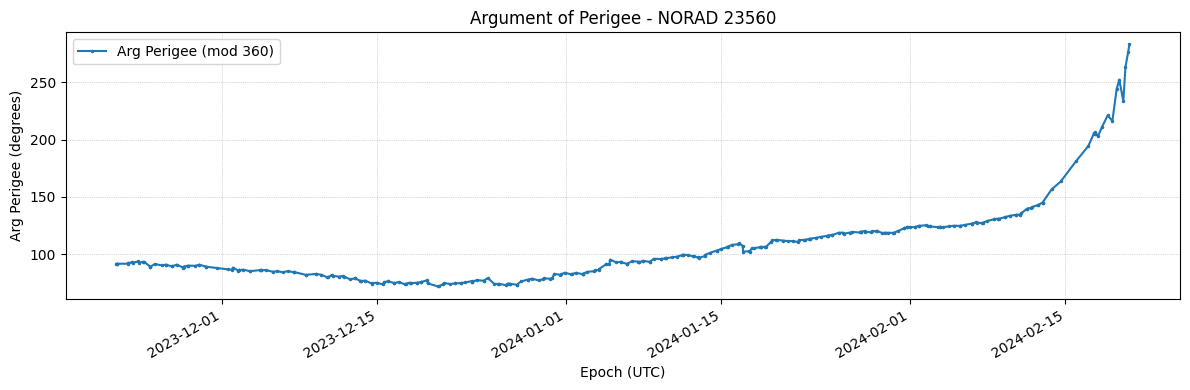

In [18]:
fig3, ax3 = plt.subplots(figsize=(12, 4))
ax3.plot(tle_df.index, tle_df['ArgPerigee_deg'] % 360, marker='.', markersize=3, linestyle='-', label='Arg Perigee (mod 360)')
ax3.set_xlabel('Epoch (UTC)')
ax3.set_ylabel('Arg Perigee (degrees)')
ax3.set_title(f'Argument of Perigee - NORAD {NORAD_ID}')
ax3.legend(loc='best')
ax3.grid(True, which='both', linestyle=':', linewidth=0.5)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig3.autofmt_xdate()
plt.tight_layout()
plt.show()

In [19]:
tle_df.head()

,MeanMotion_rad_min,MeanMotion_revday,Eccentricity,Inclination_deg,RAAN_deg,ArgPerigee_deg,MeanAnomaly_deg,Bstar,ndot_TERM_from_TLE,MeanMotion_rad_sec,SemiMajorAxis_m,SemiMajorAxis_km,Period_sec,AltitudePerigee_km,AltitudeApogee_km
Epoch,,,,,,,,,,,,,,,
2023-11-21 11:11:45.858336,0.068145,15.617630,0.000520,98.5282,318.1805,91.7948,268.3902,0.000714,0.000620,0.001136,6.760703e+06,6760.703376,5532.209372,379.052810,386.083942
2023-11-21 12:44:01.602240,0.068145,15.617783,0.000519,98.5281,318.2574,91.8769,268.3080,0.000901,0.000784,0.001136,6.760659e+06,6760.659219,5532.155172,379.017465,386.030973
2023-11-21 12:44:01.602240,0.068145,15.617783,0.000519,98.5281,318.2574,91.8769,268.3080,0.000901,0.000784,0.001136,6.760659e+06,6760.659219,5532.155172,379.017465,386.030973
2023-11-22 11:47:52.577664,0.068154,15.619751,0.000528,98.5276,319.4135,91.8969,268.2889,0.001164,0.001025,0.001136,6.760091e+06,6760.091285,5531.458088,378.388985,385.523586
2023-11-22 13:20:07.538784,0.068155,15.619960,0.000530,98.5277,319.4908,92.4440,267.7422,0.001302,0.001149,0.001136,6.760031e+06,6760.031073,5531.384186,378.311905,385.480242
